# Import librairy

In [1]:
import time # to measure time

import pandas as pd # CPU

import xgboost as xgb # model
import seaborn
from tqdm import tqdm # to display progress bar

# CPU
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing


# visualisation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from xgboost import plot_importance, plot_tree
from sklearn.utils import resample

#qiskit
import numpy as np
import math

from sklearn.svm import *
from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.decomposition import *

from qiskit import *
from qiskit.circuit.library import *
from qiskit.utils import *
from qiskit_machine_learning.algorithms import *
from qiskit_machine_learning.kernels import *
from qiskit_machine_learning.datasets import *
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
import timeit

# defining some metrics and the data set
seed = 1234

C:\Users\jerom\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jerom\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\jerom\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Load data

In [2]:
%%time

# CPU
train_transaction = pd.read_csv("C://Users/jerom/PycharmProjects/fraudData/file/train_transaction.csv")
train_identity = pd.read_csv("C://Users/jerom/PycharmProjects/fraudData/file/train_identity.csv")
#test_transaction = pd.read_csv("C://Users/jerom/PycharmProjects/fraudData/file/test_transaction.csv")
#test_identity = pd.read_csv("C://Users/jerom/PycharmProjects/fraudData/file/test_identity.csv")
train= pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

CPU times: total: 55.7 s
Wall time: 56.9 s


In [3]:
print(f'Training dataset has {train.shape[0]} observations and {train.shape[1]} features.')
#print(f'Test dataset has {test.shape[0]} observations and {test.shape[1]} features.')

Training dataset has 590540 observations and 434 features.


In [4]:
Y_train_preprocess = train["isFraud"]
X_train_preprocess = train.drop(["isFraud","TransactionID", "TransactionDT"], axis=1)
#Y_test = test["isFraud"]
#X_test = test.drop(["TransactionID", "TransactionDT","isFraud"], axis=1)

In [12]:
X_train_preprocess.shape

(590540, 223)

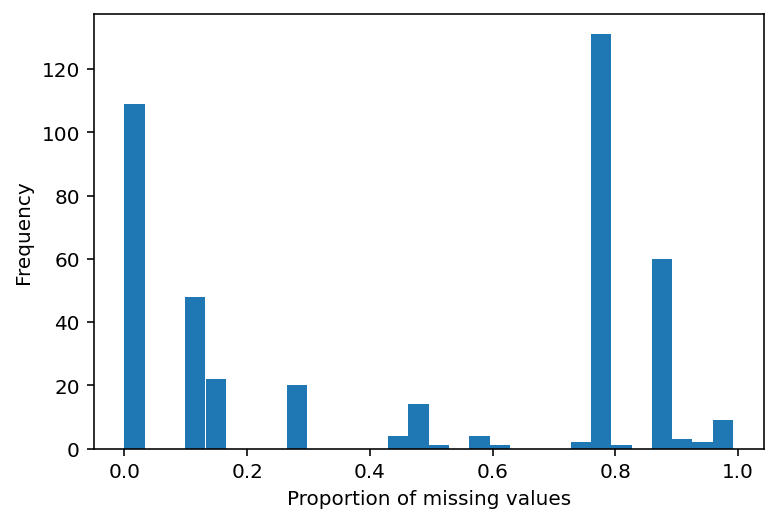

In [6]:
# proporation of missing values
missPropor = [(X_train_preprocess[col].isnull().sum()) / (X_train_preprocess.shape[0]) for col in X_train_preprocess.columns]
plt.hist(missPropor, bins=30)
plt.ylabel("Frequency")
plt.xlabel("Proportion of missing values")
plt.show()

In [7]:
many_null_cols = [X_train_preprocess.columns[i] for i in range(X_train_preprocess.shape[1]) if missPropor[i] > 0.7]

In [8]:
# delete features with high proporation of missing values
X_train_preprocess = X_train_preprocess.drop(many_null_cols, axis=1)

print(f"After deleting features with high proporation of missing values, there are {X_train_preprocess.shape[1]} features.")


After deleting features with high proporation of missing values, there are 223 features.


In [9]:
# fill missing values in categorical variables with their mode.
# fill missing values in numerical variables with their mean.
for i in range(X_train_preprocess.shape[1]):
    if missPropor[i] > 0:
        if X_train_preprocess.iloc[:, i].dtype == "object":
            X_train_preprocess.iloc[:, i] = X_train_preprocess.iloc[:, i].fillna(X_train_preprocess.iloc[:, i].mode()[0])
        elif X_train_preprocess.iloc[:, i].dtype in ['int64', 'float64']:
            X_train_preprocess.iloc[:, i] = X_train_preprocess.iloc[:, i].fillna(X_train_preprocess.iloc[:, i].mean())

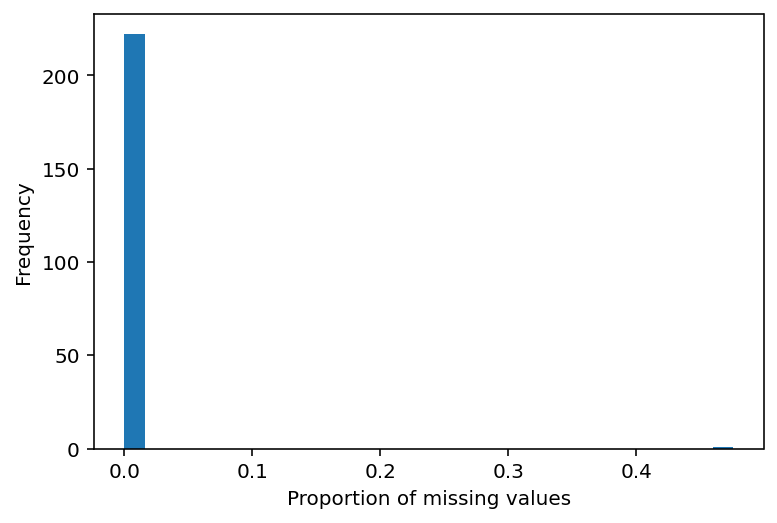

In [10]:
# proporation of missing values
missPropor = [(X_train_preprocess[col].isnull().sum()) / (X_train_preprocess.shape[0]) for col in X_train_preprocess.columns]
plt.hist(missPropor, bins=30)
plt.ylabel("Frequency")
plt.xlabel("Proportion of missing values")
plt.show()

In [11]:
X_train_preprocess.isna().sum().sum()

282066

# Data preparation

In [101]:
# numeric encoding (label encoding)
def encoding(train):
    X_le = train.copy()
    #X_te = test.copy()
    for f in train.columns:
        if X_le[f].dtype == 'object': 
            le = preprocessing.LabelEncoder()
            le.fit(list(X_le[f].values))
            X_le[f] = le.transform(list(X_le[f].values))
            #te = preprocessing.LabelEncoder()
            #te.fit(list(X_te[f].values))
            #X_te[f] = te.transform(list(X_te[f].values))
    return X_le

def normalize(X_le):
    X_le_pca = X_le.copy()
    #X_te_pca = X_te.copy()
    # standardize the data
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_le_pca)
    X_le_pca = scaler.transform(X_le_pca)
    #scaler.fit(X_te_pca)
    #X_te_pca = scaler.transform(X_te_pca)
    return pd.DataFrame(X_le_pca)

def encode_normalize(train):
    print("start encoding")
    X_le = encoding(train)
    print("start normalization")
    return normalize(X_le)

def applyPCA(nb_components,train):
    pca = PCA(n_components=nb_components)
    pca.fit(train)
    X_le_pca = pca.transform(train)
    print(f"the explained variance for the train test is {100*pca.explained_variance_ratio_}, which is {100*np.sum(pca.explained_variance_ratio_)}%")
    X_le_pca = pd.DataFrame(X_le_pca)
    #pcat = PCA(n_components=nb_components)
    #pcat.fit(test)
    #print(f"the explained variance for the test is {pcat.explained_variance_}, which is {np.sum(pcat.explained_variance_)}%")
    #X_te_pca = pcat.transform(test)
    #X_te_pca = pd.DataFrame(X_te_pca)
    
    return X_le_pca

In [104]:
%%time
X_le_pca_normalized = encode_normalize(X_train_preprocess)

start encoding
start normalization
CPU times: total: 10.4 s
Wall time: 10.5 s


In [201]:
%%time
X_le_pca = applyPCA(3,X_le_pca_normalized)

the explained variance for the train test is [16.36131759 13.5296522   4.6323584 ], which is 34.52332818638695%
CPU times: total: 44.8 s
Wall time: 8.27 s


# Balanced data set

In [228]:
data_balanced = pd.concat([X_le_pca,Y_train_preprocess],axis=1)
fraud = data_balanced[data_balanced["isFraud"] == 1]
notFraud  = data_balanced[data_balanced["isFraud"] == 0]
print("fraud data : ",fraud.shape[0]/data_balanced.shape[0]*100,"% not fraud : ", notFraud.shape[0]/data_balanced.shape[0]*100,"%")
print("nb fraud data : ", fraud.shape[0])

notFraud_downsample = resample(notFraud,
             replace=False,
             n_samples=fraud.shape[0],
             random_state=42)

print(notFraud_downsample.shape)

fraud data :  3.4990009144173126 % not fraud :  96.50099908558268 %
nb fraud data :  20663
(20663, 4)


In [229]:
train_balanced = pd.concat([fraud,notFraud_downsample])
Y_train_balanced = train_balanced["isFraud"]
train_balanced.drop(["isFraud"],axis=1)

,0,1,2
203,-2.043669,-0.285042,-0.772324
240,11.368686,-3.077040,-0.838911
243,15.860352,-3.436367,-0.778564
245,16.474712,-3.058225,-0.797503
288,15.188871,-3.822980,-0.747108
...,...,...,...
277283,-2.441889,-0.107921,-1.251080
254760,4.772560,-1.264256,-0.072332
64884,-1.195957,0.406315,-2.135500
532081,15.063619,-3.204389,-0.327595


In [230]:
# get ratio of positive cases (1) to negative cases (0)
ratio_of_positive = Y_train_balanced.sum()/(len(Y_train_balanced)-Y_train_balanced.sum())
print(round(ratio_of_positive,3), ": 1 ratio of positive:negative")

1.0 : 1 ratio of positive:negative


# reduce size

In [231]:
def reduce(data,n):
    #we want to have balanced data with has much has fraud has not fraud
    sample = int(n/2)
    print("copy data")
    train = data
    print("group data")
    train = train.groupby("isFraud",group_keys=False).apply(lambda x : x.sample(sample))
    print("split data")
    Y_reduced = train["isFraud"]
    X_reduced = train.drop("isFraud",axis=1)
    return X_reduced,Y_reduced

In [232]:
train_reduced,Y_train_reduced = reduce(train_balanced,500)

copy data
group data
split data


In [233]:
# get ratio of positive cases (1) to negative cases (0)
ratio_of_positive = Y_train_reduced.sum()/(len(Y_train_reduced)-Y_train_reduced.sum())
print(round(ratio_of_positive,3), ": 1 ratio of positive:negative")

1.0 : 1 ratio of positive:negative


In [234]:
train_reduced.shape

(500, 3)

In [235]:
Y_train_reduced.shape

(500,)

# split train test

In [236]:
data_reduced = pd.concat([train_reduced,Y_train_reduced],axis=1)
train, test_val = train_test_split(data_reduced, test_size=0.4, random_state=42, stratify=data_reduced["isFraud"])
valid, test =train_test_split(test_val, test_size=0.3, random_state=42, stratify=test_val["isFraud"])

In [237]:
train.shape

(300, 4)

In [238]:
valid.shape

(140, 4)

In [239]:
test.shape

(60, 4)

In [240]:
Y_train = train["isFraud"]
X_train=train.drop(["isFraud"],axis=1)
Y_valid = valid["isFraud"]
X_valid = valid.drop(["isFraud"],axis=1)
Y_test = test["isFraud"]
X_test=test.drop(["isFraud"],axis=1)

In [241]:
X_train.shape

(300, 3)

In [242]:
# get ratio of positive cases (1) to negative cases (0)
ratio_of_positive = Y_train.sum()/(len(Y_train)-Y_train.sum())
print("train data : ",round(ratio_of_positive,3), ": 1 ratio of positive:negative")
ratio_of_positive = Y_test.sum()/(len(Y_test)-Y_test.sum())
print("test data : ",round(ratio_of_positive,3), ": 1 ratio of positive:negative")
ratio_of_positive = Y_valid.sum()/(len(Y_valid)-Y_valid.sum())
print("valid data : ",round(ratio_of_positive,3), ": 1 ratio of positive:negative")

train data :  1.0 : 1 ratio of positive:negative
test data :  1.0 : 1 ratio of positive:negative
valid data :  1.0 : 1 ratio of positive:negative


In [243]:
Y_test[Y_test==1].shape

(30,)

# Train model

In [244]:
model = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth = 10,
    early_stopping_rounds=10,
    learning_rate=0.1,
    tree_method="exact",
    booster='gbtree',
    importance_type='gain',
    # scale up the weight of positive samples
    use_label_encoder=False,
    eval_metric=["error","logloss"]
)

#xgbc = xgb.XGBClassifier(n_jobs=4, max_depth=10, min_samples_leaf=0.001, 
                         #learning_rate=0.1, n_estimators=100, eval_metric="auc")
#xgbc.fit(Xtr, np.ravel(Ytr))
#submission["isFraud"] = xgbc.predict_proba(Xte)[:, 1]

In [245]:
# CPU
train_start_time = time.time()
eval_set=[(X_valid,Y_valid)]
model.fit(X_train, np.ravel(Y_train),eval_set=eval_set,verbose=False)

train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 0 seconds


# Prediction

In [246]:
%%time

# CPU
preds = model.predict(X_train)

CPU times: total: 0 ns
Wall time: 3.93 ms


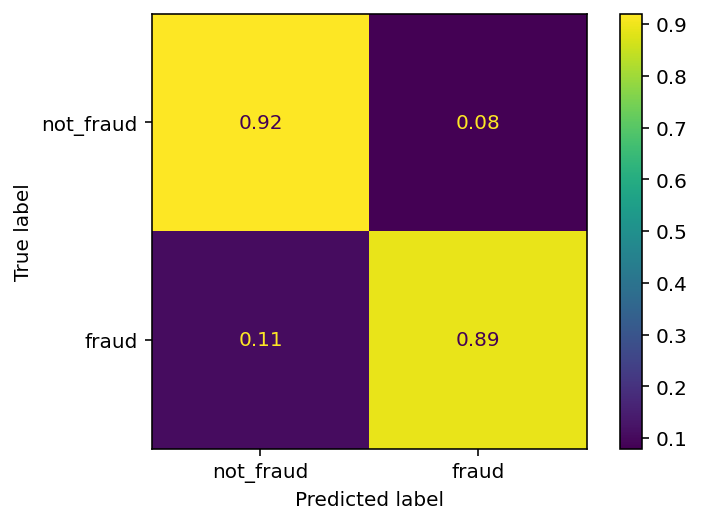

In [247]:
# CPU
# confusion matrix
cm = confusion_matrix(Y_train, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

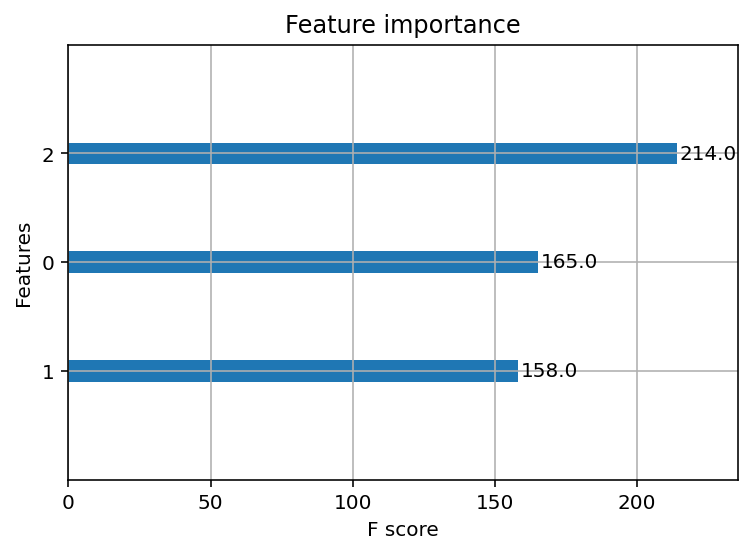

In [222]:
plot_importance(model, max_num_features=10)
plt.show()

In [223]:
print("Accuracy of Model on training set::",model.score(X_train,Y_train))

Accuracy of Model on training set:: 0.9


# Result on test data

In [224]:
preds = model.predict(X_test)

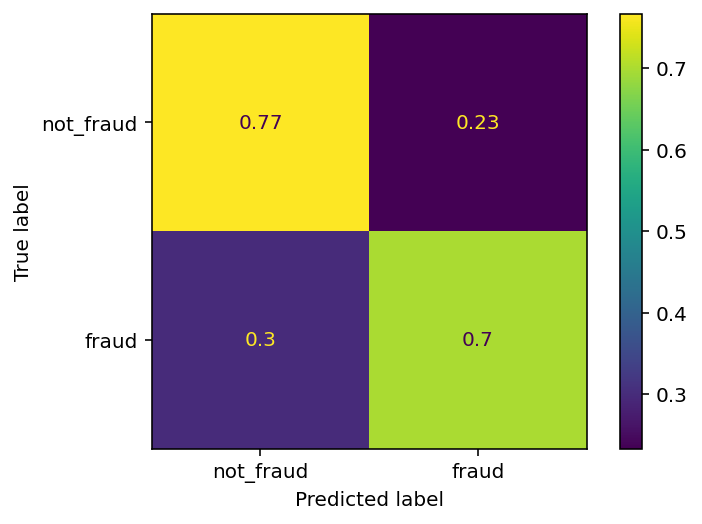

In [225]:
# CPU
# confusion matrix
cm = confusion_matrix(Y_test, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [226]:
print("Accuracy of Model on training set::",model.score(X_test,Y_test))

Accuracy of Model on training set:: 0.7333333333333333


In [227]:
X_train.to_csv("train_reduced.csv",index=False)
Y_train.to_csv("Y_train_reduced.csv",index=False)
X_valid.to_csv("valid_reduced.csv",index=False)
Y_valid.to_csv("Y_valid_reduced.csv",index=False)
X_test.to_csv("test_reduced.csv",index=False)
Y_test.to_csv("Y_test_reduced.csv",index=False)

# Quantum approach

In [1193]:
def QSVM(dimension, reps,X_reduced, Y_reduced, X_test,Y_test, precomputedKernel=False,seed=seed,shots=1024):
    # defining the backend
    print("define backend")
    start = time.time()
    ad_hoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=shots,
                                seed_simulator=seed, seed_transpiler=seed)
    end = time.time()
    print("time : ",abs(end-start))
    
    print("define feature map")
    start = time.time()
    # in this excercice we will only test for ZZfeatureMap, the input will be the number of reps
    ad_hoc_feature_map = ZZFeatureMap(feature_dimension=dimension,
                                 reps=reps, entanglement='full')
    end = time.time()
    print("time : ",abs(end-start))
    
    print("define kernel map")
    start = time.time()
    # defining the kernel
    adhoc_kernel = QuantumKernel(feature_map=ad_hoc_feature_map, quantum_instance=ad_hoc_backend)
    end = time.time()
    print("time : ",abs(end-start))
    
    
    if precomputedKernel:
        print("evaluate on train")
        start = time.time()
        adhoc_matrix_train= adhoc_kernel.evaluate(x_vec=X_reduced)
        end = time.time()
        print("time : ",abs(end-start))
        
        print("build kernel")
        start = time.time()
        engine =QSVC(kernel="precomputed")
        end = timeit.timeit()
        print("time : ",abs(end-start))
        
        print("calibrate")
        start = time.time()
        engine.fit(adhoc_matrix_train, Y_reduced)
        end = time.time()
        print("time : ",abs(end-start))
        
        print("score")
        start = time.time()
        score_train=  engine.score(adhoc_matrix_train,Y_reduced)
        end = time.time()
        print("time : ",abs(end-start))
    else:
        print("build engine")
        start = time.time()
        engine = QSVC(quantum_kernel=adhoc_kernel)
        end = time.time()
        print("time : ",end-start)
        
        # fitting the data
        print("calibrate")
        start = time.time()
        engine.fit(X_reduced, Y_reduced)
        end = time.time()
        print("time : ",end-start)
        
        print("score")
        start = time.time()
        score_train = engine.score(X_reduced, Y_reduced)
        end = time.time()
        print("time : ",end-start)
        
    print("score test")
    start = time.time()
    score_test = engine.score(X_test,Y_test)
    end = time.time()
    print("time : ",end-start)
    print("score train: ",score_train)
    print("score test: ",score_test)
    # looking at the score of the trainning data
    return engine

In [ ]:
engine= QSVM(dimension=3,reps=1,X_reduced=X_train, Y_reduced=Y_train, X_test=X_test,Y_test=Y_test)

define backend
time :  0.8588542938232422
define feature map
time :  0.0
define kernel map
time :  0.0
build engine
time :  0.0
calibrate


In [ ]:
score_train

In [ ]:
# CPU
# confusion matrix
cm = confusion_matrix(Y_test, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [ ]:
print("define backend")
ad_hoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)
print("define feature map")
# in this excercice we will only test for ZZfeatureMap, the input will be the number of reps
ad_hoc_feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=1, entanglement='full')
print("define kernel map")
# defining the kernel
adhoc_kernel = QuantumKernel(feature_map=ad_hoc_feature_map, quantum_instance=ad_hoc_backend)

In [399]:
print("process data")
X_le_pca,X_te_pca = encode_normalize(X_train,X_test)
X_le_pca,X_te_pca = applyPCA(2,X_le_pca,X_te_pca)
X_reduced, Y_reduced = reduce(X_le_pca,Y_train,25)

process data
start encoding
start normalization
the explained variance for the train test is [36.48580001 30.17117549], which is 66.65697550460558%
the explained variance for the test is [36.41338078 13.18244569], which is 49.59582646812329%
copy data
group data
split data


In [400]:
engine = QSVC(quantum_kernel=adhoc_kernel)
# fitting the data
print("calibrate")
engine.fit(X_reduced, Y_reduced)
print("score")
score_train = engine.score(X_reduced, Y_reduced)

calibrate
score


In [406]:
print(f"score train",score_train)
prediction =engine.predict(X_te_pca)

score train 0.78


KeyboardInterrupt: 

# VQC

In [128]:
print("define backend")
quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,seed_simulator=seed, seed_transpiler=seed)
print("define OpFlowQNN")
opflow_qnn = TwoLayerQNN(num_qubits = 2, quantum_instance=quantum_instance)
print("define the callback function : did not build to be consider later on")
callback_graph = None
print("define NN classifer")
opflow_classifer = NeuralNetworkClassifier(opflow_qnn,optimizer=COBYLA(),callback = callback_graph)
print("define PCA for train")
pcatrain = PCA(n_components  =2)
train_features = pcatrain.fit_transform(X_train)
print("define PCA for test")
pcatest = PCA(n_components  =2)
test_features = pcatest.fit_transform(X_valid)
print("train the model")
opflow_classifer.fit(train_features,y_train.values)


define backend
define OpFlowQNN
define the callback function : did not build to be consider later on
define NN classifer
define PCA for train
define PCA for test
train the model


KeyboardInterrupt: 

In [ ]:
print("score on training set")
opflow_classifier.score(X_train,y_train)
print("score on validation set")
opflow_classifier.score(X_test,y_test)

# QNN

In [127]:
print("contruct feature map")
feature_map = ZZFeatureMap(2)
print("construct ansatz")
ansatz = RealAmplitudes(2,reps=1)
print("cosntruct circuit")
qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))
qc.decompose().draw(output="mpl")

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
#comment from the session :
#better cleaning of the data : and then resampling
# resampling the dataset : 200 transactions : 100/100
# PCA increase : test 2, 3, 4, 5 
#need to check the explanability 

In [131]:
pcatrain = PCA(n_components  =5)
train_features = pcatrain.fit_transform(X_train)
print(pcatrain.explained_variance_ratio_)

[9.99300425e-01 5.44551561e-04 1.41077626e-04 1.03462923e-05
 1.12314824e-06]
